### Лабораторна робота №6, Штучний інтелект в задачах обробки зображень
**Виконав**: студент групи ІП-11, Лошак Віктор Іванович<br>
**Перевірив**: Нікітін В.А.<br>
**Група студентів що виконувала роботу**: Шамков Іван, Кисельов Микита, Лошак Віктор<vr>

**Тема роботи**: Реалізація архітектури AlexNet CNN за допомогою TensorFlow і Keras.<br>
**Мета роботи**: отримати навички реалізації архітектури AlexNet CNN з використанням бібліотек TensorFlow та Keras.

07.04.2024

**Завдання**:<br>
1.	Реалізувати засобами TensorFlow та Keras AlexNet;
2.	Отримати оцінку точності навченої мережі.


**Task**:<br>
1. Implement AlexNet using TensorFlow and Keras;
2. Get an estimate of the accuracy of the trained network.

##### Task 1

In [1]:
from tensorflow.keras import datasets
from tensorflow import data
import matplotlib.pyplot as plt
from numpy import argmax
from tensorflow import image as tf_image

In [1]:
batch_size = 128
epochs_count = 100
test_size = 1000
val_size = min(50_000, batch_size * epochs_count)
checkpoint_filepath = "best_model.h5"

(train_images, train_labels), (test_images, test_labels) = datasets.cifar10.load_data()

test_images, test_labels = test_images[:test_size], test_labels[:test_size]
validation_images, validation_labels = train_images[:val_size], train_labels[:val_size]
train_images, train_labels = train_images[val_size:2*val_size], train_labels[val_size:2*val_size]

train_ds = data.Dataset.from_tensor_slices((train_images, train_labels))
test_ds = data.Dataset.from_tensor_slices((test_images, test_labels))
validation_ds = data.Dataset.from_tensor_slices((validation_images, validation_labels))

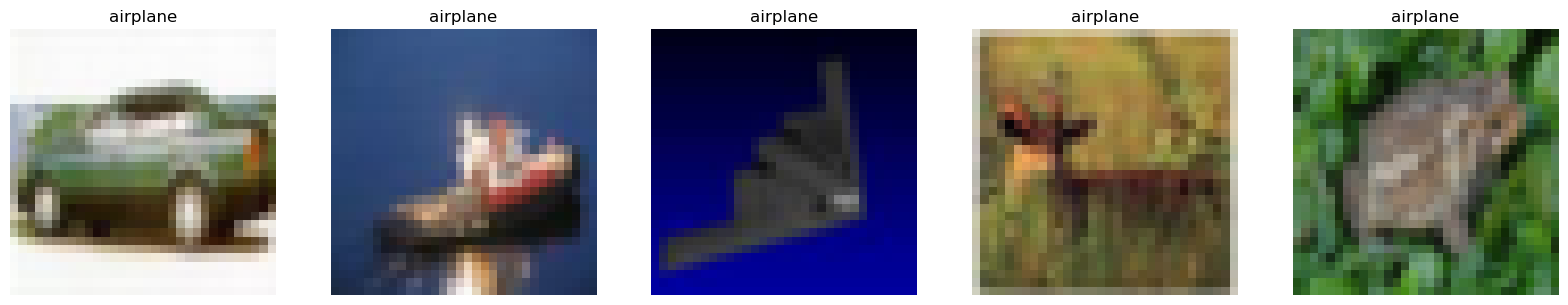

In [3]:
CLASS_NAMES = [
    "airplane", "automobile", "bird", "cat",
    "deer", "dog", "frog", "horse", "ship", "truck",
]

plt.figure(figsize=(20, 20))
for i, (image, label) in enumerate(train_ds.take(5)):
    ax = plt.subplot(5, 5, i+1)
    plt.imshow(image)
    plt.title(CLASS_NAMES[argmax(label)])
    plt.axis("off")

plt.show()

In [4]:
def process_images(image, label):
    image = tf_image.per_image_standardization(image)
    image = tf_image.resize(image, (227, 227))
    return image, label


train_ds_size = data.experimental.cardinality(train_ds).numpy()
test_ds_size = data.experimental.cardinality(test_ds).numpy()
validation_ds_size = data.experimental.cardinality(validation_ds).numpy()

print(f"{train_ds_size = }")
print(f"{test_ds_size = }")
print(f"{validation_ds_size = }")

train_ds = (train_ds
            .map(process_images)
            .shuffle(buffer_size=train_ds_size)
            .batch(batch_size=batch_size, drop_remainder=True))

test_ds = (test_ds
            .map(process_images)
            .shuffle(buffer_size=test_ds_size)
            .batch(batch_size=batch_size, drop_remainder=True))

validation_ds = (validation_ds
            .map(process_images)
            .shuffle(buffer_size=validation_ds_size)
            .batch(batch_size=batch_size, drop_remainder=True))

train_ds_size = 12800
test_ds_size = 1000
validation_ds_size = 12800


## 1.2. Побудова та компіляція моделі

In [5]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, BatchNormalization, MaxPooling2D, Flatten, Dense, Dropout
from os import path, curdir
from tensorflow.keras import callbacks
from tensorflow import optimizers


In [ ]:
model = Sequential([
    Conv2D(96, (11, 11), (4, 4), activation="relu", input_shape=(227, 227, 3)),
    BatchNormalization(),
    MaxPooling2D((3, 3), (2, 2)),
    
    Conv2D(256, (5, 5), (1, 1), activation="relu", input_shape=(227, 227, 3), padding="same"),
    BatchNormalization(),
    MaxPooling2D((3, 3), (2, 2)),

    Conv2D(384, (3, 3), (1, 1), activation="relu", input_shape=(227, 227, 3), padding="same"),
    BatchNormalization(),

    Conv2D(384, (3, 3), (1, 1), activation="relu", input_shape=(227, 227, 3), padding="same"),
    BatchNormalization(),

    Conv2D(256, (3, 3), (1, 1), activation="relu", input_shape=(227, 227, 3), padding="same"),
    BatchNormalization(),
    MaxPooling2D((3, 3), (2, 2)),

    Flatten(),

    Dense(4096, activation="relu"),
    Dropout(.5),

    Dense(4096, activation="relu"),
    Dropout(.5),

    Dense(10, activation="softmax")
])

In [6]:
run_index = 1
run_logdir = path.join(curdir, "my_cifar10_logs", "run_{:03d}".format(run_index))

def get_run_logdir():
  import time
  run_id = time.strftime("run_%Y_%m_%d-%H_%M_%S")
  return path.join(run_logdir, run_id)

In [7]:
run_logdir = get_run_logdir()
tensorboard_cb = callbacks.TensorBoard(run_logdir)

In [8]:
model.compile(
    loss="sparse_categorical_crossentropy",
    optimizer=optimizers.SGD(learning_rate=.001),
    metrics=["accuracy"]
)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 55, 55, 96)        34944     
                                                                 
 batch_normalization (BatchN  (None, 55, 55, 96)       384       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 27, 27, 96)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 27, 27, 256)       614656    
                                                                 
 batch_normalization_1 (Batc  (None, 27, 27, 256)      1024      
 hNormalization)                                                 
                                                        

## 1.3. Тренування моделі

In [9]:
import gc
from tensorflow.keras.callbacks import ModelCheckpoint


1682

In [ ]:
gc.collect()

In [10]:
checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_best_only=True,
    monitor="val_loss",
    mode="min",
    verbose=True
)

model.fit(
    train_ds,
    epochs=epochs_count,
    validation_data=validation_ds,
    validation_freq=1,
    callbacks=[tensorboard_cb, checkpoint_callback]
)

Epoch 1/100
100/100 [==============================] - ETA: 0s - loss: 3.2578 - accuracy: 0.2069
Epoch 1: val_loss improved from inf to 2.23576, saving model to best_model.h5
100/100 [==============================] - 271s 3s/step - loss: 3.2578 - accuracy: 0.2069 - val_loss: 2.2358 - val_accuracy: 0.1716
Epoch 2/100
100/100 [==============================] - ETA: 0s - loss: 2.4446 - accuracy: 0.2878
Epoch 2: val_loss improved from 2.23576 to 2.01674, saving model to best_model.h5
100/100 [==============================] - 255s 3s/step - loss: 2.4446 - accuracy: 0.2878 - val_loss: 2.0167 - val_accuracy: 0.2837
Epoch 3/100
100/100 [==============================] - ETA: 0s - loss: 2.0869 - accuracy: 0.3465
Epoch 3: val_loss improved from 2.01674 to 1.67405, saving model to best_model.h5
100/100 [==============================] - 244s 2s/step - loss: 2.0869 - accuracy: 0.3465 - val_loss: 1.6740 - val_accuracy: 0.4030
Epoch 4/100
100/100 [==============================] - ETA: 0s - loss: 

## 1.3. Візуалізація моделі

In [ ]:
from tensorflow.keras.models import load_model
from os import path, makedirs
from tensorflow.keras.utils import plot_model
from visualkeras import layered_view

In [11]:
gc.collect()

0

In [12]:
# !tensorboard --logdir logs

In [13]:
loaded_model = load_model(checkpoint_filepath)

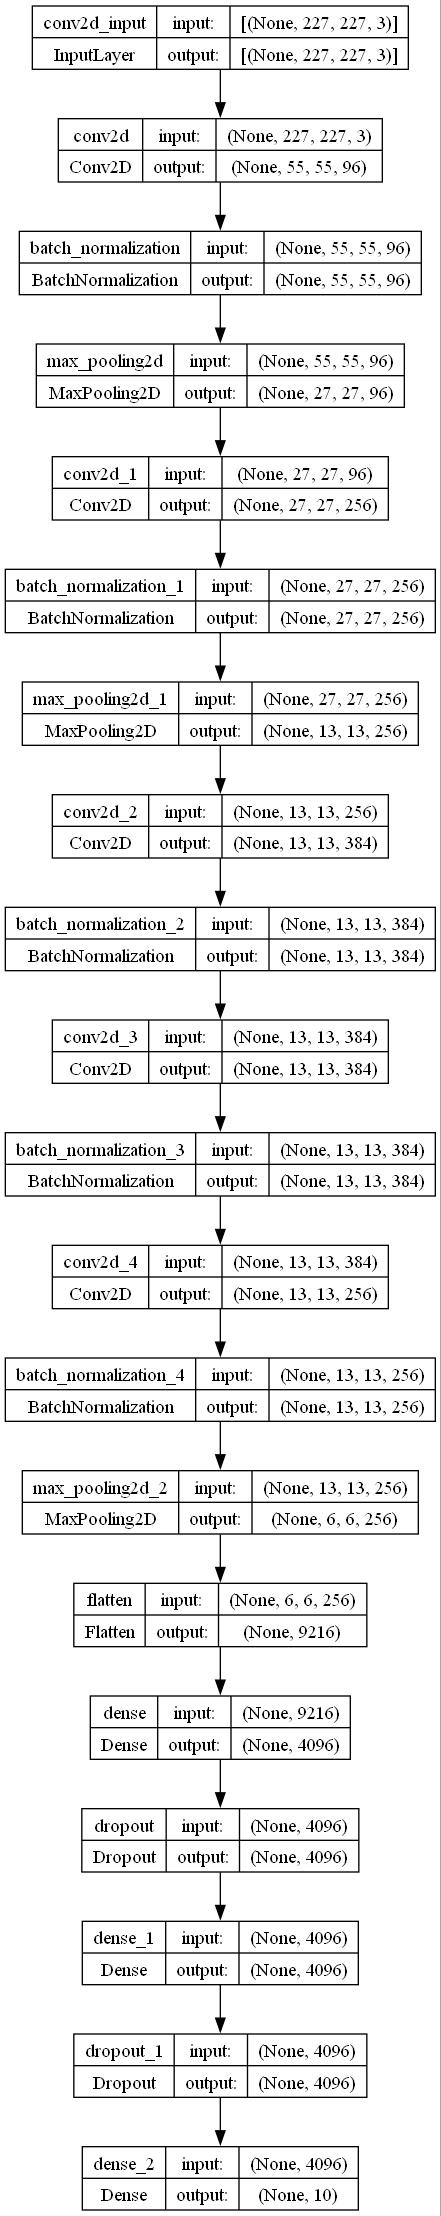

In [14]:
output_dir = "./tmp"
makedirs(output_dir, exist_ok=True)
img_file = path.join(output_dir, checkpoint_filepath + ".jpg")
plot_model(loaded_model, to_file=img_file, show_shapes=True)

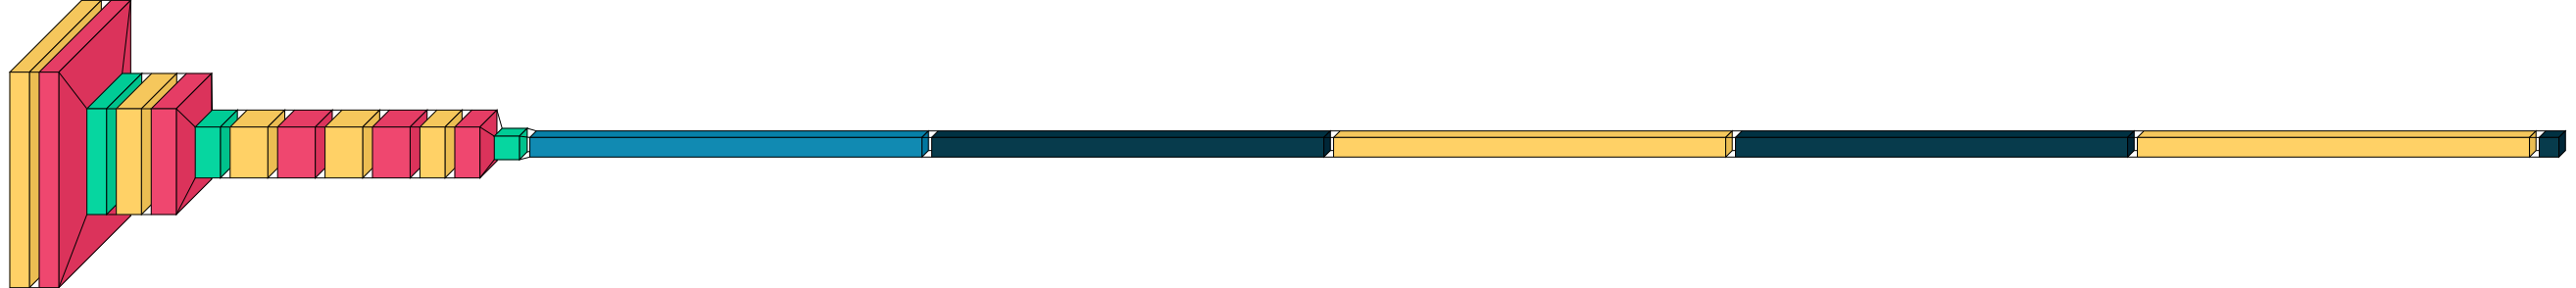

In [15]:
layered_view(loaded_model)

# 2. Отримати оцінку точності навченої мережі.

In [16]:
loss, accuracy = loaded_model.evaluate(test_ds)

7/7 [==============================] - 6s 792ms/step - loss: 0.9937 - accuracy: 0.6496


# Відповіді на контрольні запитання
## 1. Що таке AlexNet?
Це згорткова нейронна мережа, розроблена для розпізнавання зображень. Вона перемогла на конкурсі LSVRC-2012 з помилкою 15,3%, що в 1,7 рази краще за друге місце. Основні інновації включають використання ReLU для активації, dropout для регуляризації та перекриття об'єднань для зменшення розміру мережі та покращення точності.

## 2. Яка архітектура AlexNet?
Мережа має біля 3 000000 параметрів, 650000 нейронів і її навчання в 2012 році займало від п'яти до семи днів.
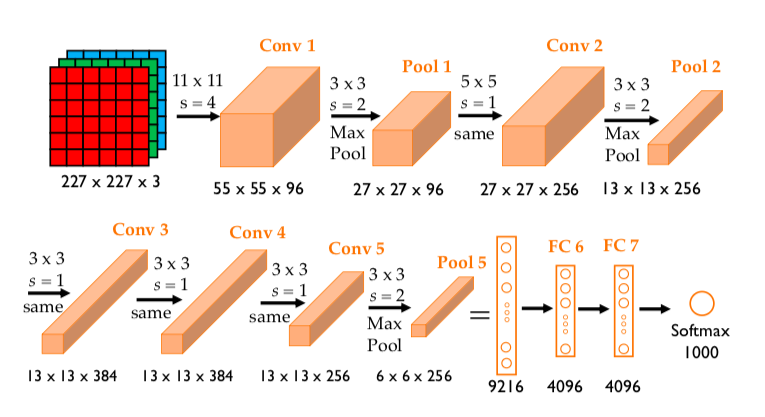

## 3. Які переваги та недоліки даної мережі?
Переваги: Вважається віхою для класифікації зображень. Використовує багато методів, які є стандартом у комп'ютерному зорі. Пряме введення зображення в модель. Ефективно виділяє візуальні шаблони. Недоліки: Недостатньо глибокий порівняно з іншими моделями. Проблеми з ініціалізацією вагових коефіцієнтів. Продуктивність перевершується складнішими моделями.

## 4. Навіщо потрібна компіляція мережі?
Процес компіляції включає визначення функції втрат, алгоритму оптимізації та швидкості навчання для ефективного навчання нейронної мережі.

## 5. Як відбувається навчання?
Через model.fit за декілька епох (ітерацій). Багатовимірний спуск функції за зазначеними налаштуваннями в model.compile (lr, оптимізатор та інше).

# Висновок
### В ході виконання даної лабораторної роботи я реалізував архітектуру AlexNet CNN з використанням бібліотек TensorFlow та Keras. Під час побудови моделі були використані згорткові шари, пакетна нормалізація, шари пулінгу, повнозв`язні шари та шари dropout для запобігання перенавчання. Модель була скомпільована з використанням оптимізатора SGD та функції втрати категоріальної крос-ентропії.
### Після тренування моделі протягом 100 епох було отримано значення точності приблизно 65% на тестовому наборі даних.
### Таким чином, лабораторна робота дозволила отримати практичні навички з реалізації та оцінки ефективності нейронних мереж в обробці зображень за допомогою штучного інтелекту.